## 0 Import all neccesary packages

In [2]:
#Within AS
# Caching Rate
import random
from multiprocessing import Queue
import sys
import sqlite3

import re
import optparse
import logging
import numpy
import logging
from visualize import visualizer as vis


import threading
from user import User

import sched, time
from topology_manager import TopologyManager, Paths, SocialPaths
import tempfile

import matplotlib.pyplot as plt
import networkx as nx

from zipf import gen_biased_zipf_requests, gen_zipf_requests, gen_bilateral_biased_zipf_requests
from Autonomous_System import AS
import warnings
warnings.filterwarnings('ignore')
from statistics import mean
import os

In [3]:
def zipf_generator(num_of_content = 100, num_of_request = 1000, offset = 0):
    alpha = 1
    req, pattern = gen_bilateral_biased_zipf_requests(alpha = 1,number_of_content = num_of_content, number_of_request = num_of_request, offset = offset)
    return pattern

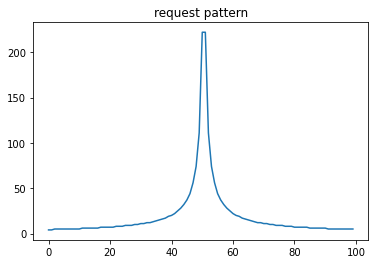

In [4]:
pattern = zipf_generator(num_of_content = 100, num_of_request = 1000, offset = 0)
plt.plot(pattern.keys(), pattern.values())
plt.title('request pattern')
plt.show()

## 1 Prepare instruaction parser

In [5]:
parser = optparse.OptionParser()
parser.add_option("-c", "--cache-size-per-node",
              dest="cache_size_per_node",
              help="space of cache allocated for every node in the topology",
              type=int,
              )
parser.add_option("-s", "--strategy",
              dest="caching_strategy",
              help="caching Strategy used for evaluating the trace"
              )
parser.add_option("-u", "--social-connections",
              dest="social_graph",
              help='social connections between users of the trace. Every trace includes users that executes actions.'
)
parser.add_option("-t", "--topology",
              dest="network_topology",
              help='network topology used for executing the trace.'
)
parser.add_option("-f", "--trace-file",
              dest="trace",
              default="",
              help='the trace to be executed',
)
parser.add_option("-p", "--replacement-policy",
              dest="replacement_policy",
              help='replacement policy used at every network node.',
)
parser.add_option("-m", "--mobility-enabled",
              dest="mobility_enabled",
              default=False,
              action="store_true",
              help="Enable mobility of users"
)
parser.add_option("-d", "--debug",
              dest="debug",
              default=False,
              action="store_true",
              help="Enable debugging options"
)
parser.add_option("-r", "--step-printing",
              dest="step_printing",
              default="",
              help = ""
)
parser.add_option("-z", "--zipf",
              dest="zipf",
              default=False,
              action="store_true",
              help = ""
)
parser.add_option("-a", "--zipf_parameter",
              dest="zipf_parameter",
              default=1.0,
              help="set zipf parameters",
              type=float,
)
parser.add_option("-e", "--method",
                 dest = "method",
                 default='random',
                 help = "random/geographical/onepublisher"
)
parser.add_option("-g", "--single-user",
                 dest = "single",
                 default=False,
                 action="store_true",
                 help = "if set, each topology node comes with only one user"
)
parser.add_option("-v", "--verbose",
                 dest = "verbose",
                 default=False,
                 action="store_true",
                 help = "if set, print cache storage info"
)

<Option at 0x1276751c0: -v/--verbose>

In [6]:
def setup_logger(logger_name, log_file, level=logging.INFO, format_style = '%(asctime)-15s %(message)s',verbose=True):
    l = logging.getLogger(logger_name)
    formatter = logging.Formatter(format_style)
    fileHandler = logging.FileHandler(log_file, mode='w')
    fileHandler.setFormatter(formatter)
    l.addHandler(fileHandler)
    streamHandler = logging.StreamHandler()
    streamHandler.setFormatter(formatter)
    l.addHandler(streamHandler)
    l.setLevel(level)
    return l

# 🤟🏻 2 define simulation program

In [7]:
class Executor(object):
    def __init__(self, logger, social_graph, topology, cache_size, caching_strategy, cache_policy, sequence_filename = '', mobility_enabled = False, step_printing = [], topology_file = None, zipf = False, method = 'random', single = False, verbose = False):
        self.lock = threading.Lock()
        self.condition = threading.Condition()
        #########################################
        #Initialize AS
        ##########################################
        nodes = list(topology.nodes())
        try:
            nodes.remove("server")
        except:
            pass
        self.AS = AS(nodes, True)
        logger.info("initialized Autonomous System")
        #########################################
        # Configuration
        #########################################
        self.round = 0
        ## Configure Cache
        self.num_of_request = 2000
        self.initialized_server = False
        self.num_of_content = 1000
        self.contents = ["/content/%s"%str(i) for i in range(self.num_of_content)]
        #########################################
        self.conf = {}
        self.conf['caching_strategy'] = caching_strategy
        self.conf['cache_policy'] = cache_policy
        self.conf['sequence_from_file'] = sequence_filename != ''
        self.conf['step_printing'] = step_printing
        self.method = method
        self.zipf_para = 1
        if self.conf['step_printing'] != None:
            self.steps = 0
        else:
            self.steps = None
        self.verbose = verbose
        #print("singledemo",single)
        #print("zipfdemo",zipf)

        ##########################################3
        # The topology manager handles user connection to CCN nodes.
        self.request_nodes = list(topology)
        self.topology = topology
        self.add_server_node()
        if single:
            self.social_nodes = self.topology
        ##############################################
        # Debugging
        #print(self.topology.nodes())
        logger.debug('Topology manager, connect users started')
        topology_coords = nx.spring_layout(topology)
        #topology_coords = {}
        #for node in topology.nodes():
        #    topology_coords[node] = (
        #            random.randint(0, 100),
        #            random.randint(0, 100)
        #    )
        self.topology_coords = topology_coords
        if single:
            self.social_graph = self.topology
            self.topology_nodes = TopologyManager(self.topology, self.topology, topology_coords, mobility_enabled, topology_file = topology_file)
        else:
            self.topology_nodes = TopologyManager(self.topology, self.social_graph, topology_coords, mobility_enabled, topology_file = topology_file)
        # 社交用户与节点之间关系为随机指定型
        # 后续的请求是用户发出的，所以，主要是要看如何将用户与请求 Pattern之间建立起关系
        self.topology_nodes.set_method(self.method)
        # 从网络中随机初始化网络节点
        # 从Social Network中随机初始化社交节点位置
        if not single:
            for user in social_graph.nodes():
                # update user node(user,pos)
                # initiate user position(coords_user)
                # 将用户映射到最近的拓扑节点上
                self.topology_nodes.update_user_position(user,(random.randint(0, 100), random.randint(0, 100)))
            self.topology_nodes.update_all_users_position()
        else:
            # 在单用户场景中，我们需要将用户初始化于相应的节点中
            for node in topology.nodes():
                    #TODO
                    self.topology_nodes.update_user_node(node,node)
        logger.debug('Topology manager, connect users finished')

        #
        self.users = {}
        for user in self.social_graph.nodes():
            self.users[user] = User(user)

        logger.debug('Start simulation')
        # debugging
        #print(self.topology_nodes.paths._path)

        self.sched = sched.scheduler(time.time, time.sleep)

        # Generate Sequence
        #print "generate sequence"
        if sequence_filename == '':
            self.generate_sequence()
        else:
            self.initialize_scheduler_from_file(sequence_filename)

        # Initialize Caches
        self.lock.acquire()
        # !!Cache Strategy Upper
        caching_strategy_upper = self.conf['caching_strategy'].upper()
        cm = getattr(getattr(__import__('cache_management.%s'%caching_strategy_upper), caching_strategy_upper), caching_strategy_upper)
        self.caches = cm(
                self.conf['cache_policy'],
                cache_size,
                self.social_graph,
                self.topology,
                self.topology_nodes,
                threshold = None
        )
        logger.debug('Loaded caching strategy')
        self.lock.release()
        self.initialize_catalog()
        ##//Initiate
    # Set Zipf parameter
    # default is 1.0
    def set_zipf_parameter(self,alpha):
        self.zipf_para = alpha
    
    def initialize_scheduler(self, offset = 0):
        self.sched = sched.scheduler(time.time, time.sleep)
        ########################
        # TODO 接上Server
        if not self.initialized_server:
            self.initialize_Server()
            self.initialized_server = True
        ##########################
        #self.extract_sequence()
        #########################
        # Pending
        # 插入ZipF请求
        print("Start Simulating!")
        self.gen_zipf_sequence(num_of_content = self.num_of_content, num_of_request = self.num_of_request, r = self.round, offset = offset)
        ######################

        assert not self.sched.empty()


    ##############################################
    #TODO: currently not being used
    def initialize_scheduler_from_file(self, filename):
        self.seq_file = open(filename, 'r')
        self.seq_n = 0
    
    def extract_sequence(self):
        line = self.seq_file.readline()
        while line != '': #Empty line, we reach the end of the sequence
            # Retrieve fields in a line
            # Line format
            # |timestamp | event | User | mobility_x | mobility_y
            result = re.match ("(?P<timestamp>[0-9]*\.[0-9]+)\t(?P<activity>Retrieve|Publish|retrieve|publish|Retrievecontent|Publishcontent)\t(?P<user>[0-9]+)\t\((?P<dependent>.*)\)\t\((?P<mobility_x>[0-9\.]*), ?(?P<mobility_y>[0-9\.]*)\)", line)
            if result != None:
                #print step result
                if self.steps != None and self.steps < len(self.conf['step_printing']) and float(result.group('timestamp')) > self.conf['step_printing'][self.steps]:
                    # debugging
                    print(self.steps)
                    self.sched.enter(self.seq_n * 0.01, 0, self.printStepSummary, (self.conf['step_printing'][self.steps],))
                    self.steps += 1
                # schedule an event (delay, priority, action, argument=())
                # delay, priority, action, argument=()
                # 使用的工具为：
                # 1 Producer2
                # 2 consumer
                # 3 consume_from_server
                pos = (float(result.group('mobility_x')), float(result.group('mobility_y')))
                if result.group('activity').lower() in ['publishcontent', 'publish']:
                    self.sched.enter(self.seq_n * 0.01, 0, self.producer2, (int(result.group('user')), pos, "/content/%s"%result.group('dependent').split(',')[0] ))
                # 两类consumer
                elif result.group(2).lower() == 'retrieve':
                    self.sched.enter(self.seq_n * 0.01, 0, self.consumer, (int(result.group('user')), pos,))
                elif result.group(2).lower() == 'retrievecontent':
                    #print(self.seq_n * 0.01, 0,self.consume_from_server, (int(result.group('user'))), pos, "/content/%s"%result.group('dependent').split(',')[0])
                    self.sched.enter(self.seq_n * 0.01, 0, self.consume_from_server, (int(result.group('user')), pos, "/content/%s"%result.group('dependent').split(',')[0]))
            else:
                print("repr line: %s"%repr(line))
                exit(-1)
            self.seq_n+=1
            line=self.seq_file.readline()
    def initialize_catalog(self):
        self.f = tempfile.NamedTemporaryFile(delete=True, dir='/tmp/')
        self.conn = sqlite3.connect(self.f.name)
        self.c = self.conn.cursor()

        #c.execute('''DROP table catalog''')
        self.c.execute('''CREATE TABLE catalog
                     (content_name text, publisher int, date double, refer text, refered_level int, topic int)''')

    def generate_sequence(self, sequence = []):
        assert type(sequence) == list
        if sequence == []:
            self.sequence = [random.randint(0, len(self.social_graph.nodes())-1) \
                for i in range(0, len(self.social_graph)*40)]
            random.shuffle(self.sequence)
        else:
            self.sequence = sequence

    ###################################
    # 加入Server节点
    def add_server_node(self):
        node = random.choice(list(self.topology.nodes()))
        self.topology.add_node("server")
        self.topology.add_edge(node,"server")
        self.server = "server"
    ############################################
    # Initialize Server
    # 随机选取一个节点
    # 作为Server接上内容
    def initialize_Server(self):
        #################################
        # TODO
        # 找到中心节点
        # 加入一个Server节点
        # Pending
        for content in self.contents:
            self.sched.enter(self.seq_n * 0.01, 0, self.producer3, (self.server, content))
        #################################

    #################################
    # 生成符合Zipf分布的请求，并插入仿真器中
    # TODO:a Zipf sequence generator
    # Pending 01 将请求插入进编辑器中
    #def generate_Zipf_sequence(self,sequence = []):
    def zipf_generator(self,num_of_content, num_of_request, offset):
        alpha = self.zipf_para
        req, _ = gen_bilateral_biased_zipf_requests(alpha = alpha,number_of_content = num_of_content, number_of_request = num_of_request, offset = offset)
        return req
        
    def gen_zipf_sequence(self, num_of_content = 1000, num_of_request = 10000, r = 0, offset = 0):
        sequence = self.zipf_generator(num_of_content, 10*num_of_content, offset)
        if len(sequence)>=num_of_request:
            requests = sequence[:num_of_request]
        else:
            while(num_of_content):
                requests += sequence[:min(num_of_sequence,len(sequence))]
        #consume_from_server(user,position, contentname)
        # nodes must convert to list, or error appears
        if self.conf['caching_strategy'].upper() == "POP":
            for request in requests:
                ##############################################
                if self.steps != None and self.steps < len(self.conf['step_printing']) and float(result.group('timestamp')) > self.conf['step_printing'][self.steps]:
                        self.sched.enter(self.seq_n * 0.01, 0, self.printStepSummary, (self.conf['step_printing'][self.steps],))
                        self.steps += 1
                ##############################################
                request_node = random.choice(self.request_nodes)
                while(request_node == "server"):
                    request_node = random.choice(self.request_nodes)
                #consume_from_server(user,position, contentname)
                #目标是先从目标节点进行查找
                ## Scheduler 的用法
                # scheduler.enter(delay, priority, action, argument=(), kwargs={})
                # Pending# consume from server 应该被改成从目标中获取
                #print(self.social_graph.nodes())
                #pos = self.topology_coords[request_node]
                #self.sched.enter(self.seq_n * 0.01, 0, self.consume_from_server, (int(result.group('user')), pos, "/content/%s"%result.group('dependent').split(',')[0]))
                req = self.contents[request]
                # print(request_node, type(pos), type(req))
                # print(self.seq_n * 0.01, 0, self.consume_from_server, request_node, pos, req)

                self.sched.enter(self.seq_n * 0.001, 0, self.consume_from_target, (request_node, req))
                self.seq_n+=1
        else:
            for request in requests:
                ##############################################
                #if self.steps != None and self.steps < len(self.conf['step_printing']) and float(result.group('timestamp')) > self.conf['step_printing'][self.steps]:
                #        self.sched.enter(self.seq_n * 0.01, 0, self.printStepSummary, (self.conf['step_printing'][self.steps],))
                #        self.steps += 1
                ##############################################
                request_node = random.choice(self.request_nodes)
                while(request_node == "server"):
                    request_node = random.choice(self.request_nodes)
                #consume_from_server(user,position, contentname)
                pos = self.topology_coords[request_node]
                req = self.contents[request]
                # print(request_node, type(pos), type(req))
                self.sched.enter(self.seq_n * 0.001, 0, self.consume_from_server,(request_node, pos, req))

            
                self.seq_n+=1
        print("total seq num: ",self.seq_n)
     #################################
    
    def run(self, offset = 0):
        #print "the process begins"
        self.initialize_scheduler(offset = offset)
        self.sched.run()
        self.round += 1
        time.sleep(2)

        
    def __del__(self):
        self.conn.close()
    # 使用的是这一个！！
    # 将文件插入到数据库中
    def producer3(self, social_publisher, content, reference = '', topic = 0):
        #self.topology_nodes.update_user_position(social_publisher, position)
        self.caches.incr_publish()
        #content_name = "/friend%i/%i"%(social_publisher, self.stats.increase_messages())
        #print("node",social_publisher, "publish",content)
        content_name = "%s"%content
        _new_content_name = content_name
        if reference == '':
            _ref_level = 0
        else:
            #Select 
            _ref_level = 0
            for row in self.c.execute('SELECT * FROM catalog WHERE content_name=\"%s\" LIMIT 1'%reference):
                _ref_level = row[4]+1
                _new_content_name = row[0]
                topic = row[5]
            assert _ref_level == 1, _ref_level
        self.c.execute("INSERT INTO catalog VALUES (\"%s\",'%s', '%s', '%s', %d, %d);"%(content_name, social_publisher, time.time(), reference, _ref_level, topic))
        self.lock.acquire()
        self.caches.post_production(_new_content_name, social_publisher)
        self.lock.release()
    # 使用的是这一个！！
    # 将文件插入到数据库中
    def producer2(self, social_publisher, position, content, reference = '', topic = 0):
        self.topology_nodes.update_user_position(social_publisher, position)
        self.caches.incr_publish()
        #content_name = "/friend%i/%i"%(social_publisher, self.stats.increase_messages())
        #print("node",social_publisher, "publish",content)
        content_name = "%s"%content
        _new_content_name = content_name
        if reference == '':
            _ref_level = 0
        else:
            #Select 
            _ref_level = 0
            for row in self.c.execute('SELECT * FROM catalog WHERE content_name=\"%s\" LIMIT 1'%reference):
                _ref_level = row[4]+1
                _new_content_name = row[0]
                topic = row[5]
            assert _ref_level == 1, _ref_level
        self.c.execute("INSERT INTO catalog VALUES (\"%s\",'%s', '%s', '%s', %d, %d);"%(content_name, social_publisher, time.time(), reference, _ref_level, topic))
        self.lock.acquire()
        self.caches.post_production(_new_content_name, social_publisher)
        self.lock.release()
    ## Producer with position This is already abandoned~
    def producer(self, social_publisher, position, reference = '', topic = 0):
        logger.error("WARNING, this function is deprecated")
        exit(-1)
        self.topology_nodes.update_user_position(social_publisher, position)
        self.caches.incr_publish()
        content_name = "/friend%i/%i"%(social_publisher, self.stats.increase_messages())
        _new_content_name = content_name
        if reference == '':
            _ref_level = 0
            topic = self.users[social_publisher].decide_next_topic()
        else:
            #Select 
            _ref_level = 0
            for row in self.c.execute('SELECT * FROM catalog WHERE content_name=\"%s\" LIMIT 1'%reference):
                _ref_level = row[4]+1
                _new_content_name = row[0]
                topic = row[5]
            assert _ref_level == 1, _ref_level
        self.c.execute("INSERT INTO catalog VALUES (\"%s\",'%s', '%s', '%s', %d, %d);"%(content_name, social_publisher, time.time(), reference, _ref_level, topic))
        self.lock.acquire()
        self.caches.post_production(_new_content_name, social_publisher)
        self.lock.release()
    #consume_from_server(user,position, contentname)
    def consume_from_server(self, social_issuer, position, content_name):
        #print("Here")
        #print "consume_from_server %s"%content_name
        # 首先将用户的位置进行更新为新的地点
        self.topology_nodes.update_user_position(social_issuer, position)
        # 然后
        content_retrieved = {}
        last = 0
        #寻找到存储这个内容的节点
        # Print Flag
        #print("Consume: ",content_name)
        for row in self.c.execute('SELECT * FROM catalog WHERE content_name == \"%s\" LIMIT 1'%( content_name )):
            # row的格式是：
            # content_name text, publisher int, date double, refer text, refered_level int, topic int
            last = row[0]
            reference = row[3]
            referer_level = row[4]
            topic = row[5]
            interest = last
            #从拓扑图中获取路径
            # 由于获取的时候
            # Print Flag
            
            path = self.topology_nodes.get_path(social_issuer, row[1])
            # Retrieve content and calculate statistics
            self.lock.acquire()
            self.caches._retrieve_from_caches(interest, path)
            self.lock.release()
        #if self.verbose:
        #    print(self.printStats())

    def consumer(self, social_issuer, position):
        self.topology_nodes.update_user_position(social_issuer, position)
        content_retrieved = {}
        for social_neighbour in self.social_graph.neighbors(social_issuer):
            topology_neighbour = self.topology_nodes[social_neighbour]
            last = 0
            
            for row in self.c.execute('SELECT * FROM catalog WHERE publisher=%s and date BETWEEN %2f AND %2f ORDER BY date DESC LIMIT 1'%(social_neighbour, time.time()-0.2, time.time())):
                last = row[0]
                reference = row[3]
                referer_level = row[4]
                topic = row[5]
                #detecting original consumer
                while referer_level > 0:
                    for row in self.c.execute('SELECT * FROM catalog WHERE content_name=\"%s\" ORDER BY date DESC LIMIT 1'%reference):
                        last = row[0]
                        reference = row[3]
                        referer_level = row[4]
                        topic = row[5]
                #print row
                interest = last
                path = self.topology_nodes.get_path(social_issuer, social_neighbour)
                self.lock.acquire()
                self.caches._retrieve_from_caches(interest, path)
                self.lock.release()
            if self.verbose:
                print(self.printStats())
#########################################################
    # TODO: 先从目标节点中尝试获取缓存信息，然后再尝试从Server处获取缓存信息
    # Pending 02
    def consume_from_target(self, consumer, content_name) :
        # 目标节点
        # Pending： 需要向目标节点发出请求
        # target = hash_target(content_name)
        content_retrieved = False
        target = self.AS.get_node(content_name)
        #print("Consume: ",content_name,"Target is: ", target)
        path_to_target = self.topology_nodes.get_path(consumer, target)
        path_to_server = self.topology_nodes.get_path(consumer, self.server)
        target_to_server = self.topology_nodes.get_path(target,self.server)
        self.lock.acquire()
        self.caches.stats.add_original_hop(len(path_to_server)-1)
        self.caches.retrieve_content(content_name, target, path_to_target,self.server, target_to_server)
        #try:
            #  从目标节点中进行获取内容
            # retrieve_content(self, interest, target, path_to_target, server, path_to_server):
        #    self.caches.retrieve_content(content_name, target, path_to_target,self.server, target_to_server)
        #except:
        #    self.caches._retrieve_from_caches(content_name, path_to_server)
        self.lock.release()
        #if self.verbose:
        #    print(self.printStats())
        return 0
#########################################################
    def get_expired_elements(self):
        # get last element of each social user
        #TODO: refactoring URGENT!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        return 0
    def get_diversity(self):
        return self.stats.get_diversity(self.caches)
    def printStats(self):
        return self.caches.stats_summary()
    #############################################
    # print cache detail
    def printCaches(self):
        return self.caches.print_caches()
    ##############################################
    def printStepSummary(self, timestamp):
        print("=> {0} {1}".format(timestamp, self.caches.stats_summary()))
    def finishSimulation(self):
        del self.caches
        del self.topology_nodes 
        del self.sched
        self.c.close()
        self.lock.acquire()
        self.lock.release()
        self.condition.acquire()
        self.condition.notify()
        self.condition.release()

## 3 😋 Clear logger block

In [8]:
logger = logging.getLogger('logger')
while logger.handlers:
    logger.handlers.pop()
cache_info = logging.getLogger('cache_info')
while cache_info.handlers:
    cache_info.handlers.pop()
    cache_info = logging.getLogger('cache_info')

In [9]:
from importlib import reload
logging.shutdown()
reload(logging)

<module 'logging' from '/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/logging/__init__.py'>

## 4 😯Configure and run for different cache_size

In [10]:
import warnings
warnings.filterwarnings('ignore')

In [11]:
def simulate(options):
    logger = setup_logger('logger', 'example.log', level=logging.CRITICAL)
    cache_info = setup_logger('cache_info', 'cache_info.log', level = logging.CRITICAL)
    if options.debug:
        root = logging.getLogger()
        root.setLevel(logging.DEBUG)
        ch = logging.StreamHandler(sys.stdout)
        ch.setLevel(logging.DEBUG)
        formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
        ch.setFormatter(formatter)
        root.addHandler(ch)
        root.info('Enable Debugging')
        # delivering original parameters
    CACHE_SIZE = options.cache_size_per_node
    CACHING_STRATEGY = options.caching_strategy
    ## Configure Cache
    RUNS = 10
    SOCIAL_GRAPH = options.social_graph
    TOPOLOGY_GRAPH = options.network_topology
    CACHE_STRUCTURE = options.replacement_policy
    SEQUENCE_FILE = options.trace
    ZIPF = options.zipf
    SINGLE = options.single
    VERBOSE = options.verbose
    if SEQUENCE_FILE == "":
        logging.error("no trace file, using random generation of messages.")
        exit()
    METHOD = options.method
    if METHOD not in ['random','geographical','onepublisher']:
        root.error("WARNING, method is not listed, set to random")
        METHOD = 'random'
    MOBILITY_ENABLED = options.mobility_enabled
    if MOBILITY_ENABLED:
        root.debug("Mobility enabled")
    else:
        root.debug("Mobility disabled")

    try:
        STEP_PRINTING = [float(x) for x in options.step_printing.split(",") if x != '']
        root.debug("Step printing activated")
    except IndexError:
        STEP_PRINTING = []
        root.debug("Step printing not activated")
    CACHE_STRUCTURE = re.match('([a-zA-Z0-9_]*(\((?P<params>([0-9]*\.?[0-9]*,? ?)*)\))?)', CACHE_STRUCTURE)
    assert CACHE_STRUCTURE != None
    CACHE_STRUCTURE = CACHE_STRUCTURE.group(1)
    # Import Social Graph
    # Social Graph from folder graphs
    G = getattr(__import__('graphs.%s'%SOCIAL_GRAPH), SOCIAL_GRAPH).G
    #plotGraph(G)
    root.debug('Social Graph loaded')
    #random.seed(10442)
    # Import Topology Graph as a new class(peterson and pharse as topology class)
    # social_graph is imported as a new class from folder graph, in this case, alibama
    petersen = getattr(__import__('graphs.%s'%TOPOLOGY_GRAPH), TOPOLOGY_GRAPH).G
    #plotGraph(petersen)
    # social_graph, topology, cache_size, caching_strategy, cache_policy, sequence_filename, mobility_enabled, step_printing, topology_file
    executor = Executor(logger,G, petersen, CACHE_SIZE, CACHING_STRATEGY, CACHE_STRUCTURE, SEQUENCE_FILE, MOBILITY_ENABLED, STEP_PRINTING, topology_file=TOPOLOGY_GRAPH, zipf = ZIPF, method = METHOD, single = SINGLE, verbose = VERBOSE) 
    offset = [0,2,4,6,8,10,12,14,16,18,20]
    for i in range(0, RUNS):
        #print(executor.caches.print_caches())
        print("#####################################################################")
        print("Round# ", i+1)
        %time executor.run(offset = offset[i])
        try:
            executor.caches.update_predict_result()
        except:
            "Not POP, do not update prediction"
        print(executor.printStats())
        if options.caching_strategy.upper() == "POP":
            result.append(executor.caches.stats._internal_hit)
        else:
            result.append(executor.caches.stats._hit)
        #print(executor.caches.print_caches())
        executor.caches.stats.reset()
        executor.seq_n = 0
        #print(executor.caches.pop)
    executor.finishSimulation()
    root.handlers.pop()
    logger = logging.getLogger('logger')
    while logger.handlers:
        logger.handlers.pop()
    cache_info = logging.getLogger('cache_info')
    while cache_info.handlers:
        cache_info.handlers.pop()

### 4.01 😎 Run POP(Zipf = 1, requests = 2000, topo = GEANT, hit_rate VS capability)

In [12]:
import warnings
warnings.filterwarnings('ignore')

In [13]:
args = '-c 5 -s pop -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True'
(options,args) = parser.parse_args(args.split(' '))

In [14]:
args = '-c 5 -s pop -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate(options)

2021-05-28 09:57:35,991 - root - INFO - Enable Debugging
2021-05-28 09:57:35,991 - root - DEBUG - Mobility disabled
2021-05-28 09:57:35,992 - root - DEBUG - Step printing activated
2021-05-28 09:57:36,029 - root - DEBUG - Social Graph loaded
#####################################################################
Round#  1
Start Simulating!
total seq num:  2000
CPU times: user 152 ms, sys: 14.9 ms, total: 167 ms
Wall time: 4.02 s
Round: 1 , internal_hit: 911 , internal_miss: 1089 , stretch : 2622 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 1089 eviction_operations: 1089 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  2
Start Simulating!
total seq num:  2000
CPU times: user 156 ms, sys: 14.7 ms, total: 171 ms
Wall time: 4.03 s
Round: 2 , internal_hit: 988 , internal_miss: 1012 , stretch : 2414 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_ope

/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Finished making prediction! 
Round: 3 , internal_hit: 939 , internal_miss: 1061 , stretch : 2522 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 1061 eviction_operations: 1061 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  4
Start Simulating!
total seq num:  2000
CPU times: user 159 ms, sys: 14.9 ms, total: 174 ms
Wall time: 4.01 s
Making prediction!


/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Finished making prediction! 
Round: 4 , internal_hit: 1189 , internal_miss: 811 , stretch : 1941 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 85 eviction_operations: 85 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  5
Start Simulating!
total seq num:  2000
CPU times: user 154 ms, sys: 14.1 ms, total: 168 ms
Wall time: 4.01 s
Making prediction!


/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Finished making prediction! 
Round: 5 , internal_hit: 1195 , internal_miss: 805 , stretch : 1898 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 56 eviction_operations: 56 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  6
Start Simulating!
total seq num:  2000
CPU times: user 164 ms, sys: 15.1 ms, total: 179 ms
Wall time: 4.01 s
Making prediction!


/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Finished making prediction! 
Round: 6 , internal_hit: 1223 , internal_miss: 777 , stretch : 1864 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 53 eviction_operations: 53 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  7
Start Simulating!
total seq num:  2000
CPU times: user 157 ms, sys: 14.2 ms, total: 171 ms
Wall time: 4.01 s
Making prediction!


/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Finished making prediction! 
Round: 7 , internal_hit: 1230 , internal_miss: 770 , stretch : 1795 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 46 eviction_operations: 46 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  8
Start Simulating!
total seq num:  2000
CPU times: user 155 ms, sys: 14.1 ms, total: 169 ms
Wall time: 4.01 s
Making prediction!


/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Finished making prediction! 
Round: 8 , internal_hit: 1215 , internal_miss: 785 , stretch : 1818 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 63 eviction_operations: 63 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  9
Start Simulating!
total seq num:  2000
CPU times: user 165 ms, sys: 15 ms, total: 180 ms
Wall time: 4.01 s
Making prediction!


/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Finished making prediction! 
Round: 9 , internal_hit: 1262 , internal_miss: 738 , stretch : 1767 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 54 eviction_operations: 54 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  10
Start Simulating!
total seq num:  2000
CPU times: user 160 ms, sys: 14.4 ms, total: 174 ms
Wall time: 4.01 s
Making prediction!


/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Finished making prediction! 
Round: 10 , internal_hit: 1251 , internal_miss: 749 , stretch : 1793 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 50 eviction_operations: 50 Satisfied by caches: 0 _interest: 0, get_rch: 0


In [14]:
result_10 = result

In [31]:
args = '-c 8 -s pop -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate(options)

2021-05-26 16:16:09,440 - root - INFO - Enable Debugging
2021-05-26 16:16:09,442 - root - DEBUG - Mobility disabled
2021-05-26 16:16:09,442 - root - DEBUG - Step printing activated
2021-05-26 16:16:09,442 - root - DEBUG - Social Graph loaded
#####################################################################
Round#  1
Start Simulating!
total seq num:  2000
CPU times: user 251 ms, sys: 20.7 ms, total: 272 ms
Wall time: 22 s
Round: 1 , internal_hit: 1064 , internal_miss: 936 , stretch : 2231 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 936 eviction_operations: 936 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  2
Start Simulating!
total seq num:  2000
CPU times: user 256 ms, sys: 19.4 ms, total: 275 ms
Wall time: 22 s
Round: 2 , internal_hit: 1148 , internal_miss: 852 , stretch : 2024 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operation

In [33]:
result_16 = result

In [15]:
args = '-c 3 -s pop -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate(options)

2021-05-26 14:28:59,286 - root - INFO - Enable Debugging
2021-05-26 14:28:59,287 - root - DEBUG - Mobility disabled
2021-05-26 14:28:59,287 - root - DEBUG - Step printing activated
2021-05-26 14:28:59,287 - root - DEBUG - Social Graph loaded
#####################################################################
Round#  1
Start Simulating!
total seq num:  2000
CPU times: user 280 ms, sys: 25.4 ms, total: 305 ms
Wall time: 22 s
Round: 1 , internal_hit: 762 , internal_miss: 1238 , stretch : 2974 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 1238 eviction_operations: 1238 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  2
Start Simulating!
total seq num:  4000
CPU times: user 311 ms, sys: 23 ms, total: 334 ms
Wall time: 42 s
Round: 2 , internal_hit: 748 , internal_miss: 1252 , stretch : 2931 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operation

/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Finished making prediction! 
Round: 3 , internal_hit: 778 , internal_miss: 1222 , stretch : 2992 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 1222 eviction_operations: 1222 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  4
Start Simulating!
total seq num:  8000
CPU times: user 302 ms, sys: 27.5 ms, total: 329 ms
Wall time: 1min 22s
Making prediction!


/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Finished making prediction! 
Round: 4 , internal_hit: 1020 , internal_miss: 980 , stretch : 2357 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 50 eviction_operations: 50 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  5
Start Simulating!
total seq num:  10000
CPU times: user 50.8 ms, sys: 2.23 ms, total: 53.1 ms
Wall time: 2min 6s
Making prediction!


/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Finished making prediction! 
Round: 5 , internal_hit: 1039 , internal_miss: 961 , stretch : 2319 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 40 eviction_operations: 40 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  6
Start Simulating!
total seq num:  12000
CPU times: user 220 ms, sys: 19.5 ms, total: 240 ms
Wall time: 2min 2s
Making prediction!


/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Finished making prediction! 
Round: 6 , internal_hit: 960 , internal_miss: 1040 , stretch : 2482 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 33 eviction_operations: 33 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  7
Start Simulating!
total seq num:  14000
CPU times: user 216 ms, sys: 20.3 ms, total: 236 ms
Wall time: 2min 22s
Making prediction!


/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Finished making prediction! 
Round: 7 , internal_hit: 843 , internal_miss: 1157 , stretch : 2672 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 25 eviction_operations: 25 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  8
Start Simulating!
total seq num:  16000
CPU times: user 192 ms, sys: 18.6 ms, total: 211 ms
Wall time: 2min 42s
Making prediction!


/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Finished making prediction! 
Round: 8 , internal_hit: 769 , internal_miss: 1231 , stretch : 2880 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 29 eviction_operations: 29 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  9
Start Simulating!
total seq num:  18000
CPU times: user 189 ms, sys: 19.2 ms, total: 208 ms
Wall time: 3min 2s
Making prediction!


/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Finished making prediction! 
Round: 9 , internal_hit: 638 , internal_miss: 1362 , stretch : 3279 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 26 eviction_operations: 26 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  10
Start Simulating!
total seq num:  20000
CPU times: user 240 ms, sys: 21.8 ms, total: 262 ms
Wall time: 3min 22s
Making prediction!


/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Finished making prediction! 
Round: 10 , internal_hit: 836 , internal_miss: 1164 , stretch : 2766 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 21 eviction_operations: 21 Satisfied by caches: 0 _interest: 0, get_rch: 0


/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [16]:
result_6 = result

In [17]:
args = '-c 13 -s pop -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate(options)

2021-05-26 14:48:24,403 - root - INFO - Enable Debugging
2021-05-26 14:48:24,403 - root - DEBUG - Mobility disabled
2021-05-26 14:48:24,404 - root - DEBUG - Step printing activated
2021-05-26 14:48:24,404 - root - DEBUG - Social Graph loaded
#####################################################################
Round#  1
Start Simulating!
total seq num:  2000
CPU times: user 249 ms, sys: 21.2 ms, total: 270 ms
Wall time: 22 s
Round: 1 , internal_hit: 1294 , internal_miss: 706 , stretch : 1670 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 706 eviction_operations: 706 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  2
Start Simulating!
total seq num:  4000
CPU times: user 229 ms, sys: 18 ms, total: 247 ms
Wall time: 42 s
Round: 2 , internal_hit: 1366 , internal_miss: 634 , stretch : 1563 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations:

/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Finished making prediction! 
Round: 3 , internal_hit: 1350 , internal_miss: 650 , stretch : 1570 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 650 eviction_operations: 650 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  4
Start Simulating!
total seq num:  8000
CPU times: user 190 ms, sys: 18.4 ms, total: 208 ms
Wall time: 1min 22s
Making prediction!


/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Finished making prediction! 
Round: 4 , internal_hit: 1478 , internal_miss: 522 , stretch : 1257 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 114 eviction_operations: 114 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  5
Start Simulating!
total seq num:  10000
CPU times: user 194 ms, sys: 18.2 ms, total: 212 ms
Wall time: 1min 42s
Making prediction!


/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Finished making prediction! 
Round: 5 , internal_hit: 1508 , internal_miss: 492 , stretch : 1189 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 110 eviction_operations: 110 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  6
Start Simulating!
total seq num:  12000
CPU times: user 327 ms, sys: 30.8 ms, total: 358 ms
Wall time: 2min 2s
Making prediction!


/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Finished making prediction! 
Round: 6 , internal_hit: 1495 , internal_miss: 505 , stretch : 1185 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 102 eviction_operations: 102 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  7
Start Simulating!
total seq num:  14000
CPU times: user 232 ms, sys: 22.7 ms, total: 255 ms
Wall time: 2min 22s
Making prediction!


/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Finished making prediction! 
Round: 7 , internal_hit: 1527 , internal_miss: 473 , stretch : 1107 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 88 eviction_operations: 88 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  8
Start Simulating!
total seq num:  16000
CPU times: user 231 ms, sys: 23.7 ms, total: 255 ms
Wall time: 2min 42s
Making prediction!


/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Finished making prediction! 
Round: 8 , internal_hit: 1516 , internal_miss: 484 , stretch : 1159 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 99 eviction_operations: 99 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  9
Start Simulating!
total seq num:  18000
CPU times: user 212 ms, sys: 20.3 ms, total: 232 ms
Wall time: 3min 2s
Making prediction!


/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Finished making prediction! 
Round: 9 , internal_hit: 1500 , internal_miss: 500 , stretch : 1201 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 123 eviction_operations: 123 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  10
Start Simulating!
total seq num:  20000
CPU times: user 120 ms, sys: 9.4 ms, total: 129 ms
Wall time: 3min 22s
Making prediction!


/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Finished making prediction! 
Round: 10 , internal_hit: 1503 , internal_miss: 497 , stretch : 1222 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 99 eviction_operations: 99 Satisfied by caches: 0 _interest: 0, get_rch: 0


In [18]:
result_26 = result

In [19]:
args = '-c 15 -s pop -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate(options)

2021-05-26 15:07:24,334 - root - INFO - Enable Debugging
2021-05-26 15:07:24,335 - root - DEBUG - Mobility disabled
2021-05-26 15:07:24,335 - root - DEBUG - Step printing activated
2021-05-26 15:07:24,335 - root - DEBUG - Social Graph loaded
#####################################################################
Round#  1
Start Simulating!
total seq num:  2000
CPU times: user 206 ms, sys: 17 ms, total: 223 ms
Wall time: 22 s
Round: 1 , internal_hit: 1312 , internal_miss: 688 , stretch : 1623 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 688 eviction_operations: 688 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  2
Start Simulating!
total seq num:  4000
CPU times: user 232 ms, sys: 20.1 ms, total: 252 ms
Wall time: 42 s
Round: 2 , internal_hit: 1423 , internal_miss: 577 , stretch : 1363 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations:

/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Finished making prediction! 
Round: 3 , internal_hit: 1411 , internal_miss: 589 , stretch : 1382 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 589 eviction_operations: 589 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  4
Start Simulating!
total seq num:  8000
CPU times: user 188 ms, sys: 17.3 ms, total: 205 ms
Wall time: 1min 22s
Making prediction!


/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Finished making prediction! 
Round: 4 , internal_hit: 1485 , internal_miss: 515 , stretch : 1278 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 152 eviction_operations: 152 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  5
Start Simulating!
total seq num:  10000
CPU times: user 191 ms, sys: 18.2 ms, total: 210 ms
Wall time: 1min 42s
Making prediction!


/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Finished making prediction! 
Round: 5 , internal_hit: 1531 , internal_miss: 469 , stretch : 1099 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 103 eviction_operations: 103 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  6
Start Simulating!
total seq num:  12000
CPU times: user 201 ms, sys: 18 ms, total: 219 ms
Wall time: 2min 2s
Making prediction!


/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Finished making prediction! 
Round: 6 , internal_hit: 1560 , internal_miss: 440 , stretch : 1045 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 109 eviction_operations: 109 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  7
Start Simulating!
total seq num:  14000
CPU times: user 240 ms, sys: 23.6 ms, total: 263 ms
Wall time: 2min 22s
Making prediction!


/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Finished making prediction! 
Round: 7 , internal_hit: 1571 , internal_miss: 429 , stretch : 1032 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 94 eviction_operations: 94 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  8
Start Simulating!
total seq num:  16000
CPU times: user 55.4 ms, sys: 3.4 ms, total: 58.8 ms
Wall time: 2min 52s
Making prediction!


/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Finished making prediction! 
Round: 8 , internal_hit: 1583 , internal_miss: 417 , stretch : 997 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 103 eviction_operations: 103 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  9
Start Simulating!
total seq num:  18000
CPU times: user 192 ms, sys: 19.4 ms, total: 212 ms
Wall time: 3min 2s
Making prediction!


/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Finished making prediction! 
Round: 9 , internal_hit: 1571 , internal_miss: 429 , stretch : 1029 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 117 eviction_operations: 117 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  10
Start Simulating!
total seq num:  20000
CPU times: user 217 ms, sys: 21.6 ms, total: 239 ms
Wall time: 3min 22s
Making prediction!


/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Finished making prediction! 
Round: 10 , internal_hit: 1554 , internal_miss: 446 , stretch : 1033 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 118 eviction_operations: 118 Satisfied by caches: 0 _interest: 0, get_rch: 0


/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [20]:
result_30 = result

In [21]:
args = '-c 18 -s pop -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate(options)

2021-05-26 15:26:35,355 - root - INFO - Enable Debugging
2021-05-26 15:26:35,355 - root - DEBUG - Mobility disabled
2021-05-26 15:26:35,355 - root - DEBUG - Step printing activated
2021-05-26 15:26:35,356 - root - DEBUG - Social Graph loaded
#####################################################################
Round#  1
Start Simulating!
total seq num:  2000
CPU times: user 224 ms, sys: 19.5 ms, total: 243 ms
Wall time: 22 s
Round: 1 , internal_hit: 1362 , internal_miss: 638 , stretch : 1514 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 638 eviction_operations: 638 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  2
Start Simulating!
total seq num:  4000
CPU times: user 223 ms, sys: 18.2 ms, total: 241 ms
Wall time: 42 s
Round: 2 , internal_hit: 1471 , internal_miss: 529 , stretch : 1281 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operation

/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Finished making prediction! 
Round: 3 , internal_hit: 1507 , internal_miss: 493 , stretch : 1169 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 493 eviction_operations: 493 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  4
Start Simulating!
total seq num:  8000
CPU times: user 65.2 ms, sys: 2.11 ms, total: 67.3 ms
Wall time: 2min 49s
Making prediction!


/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Finished making prediction! 
Round: 4 , internal_hit: 1584 , internal_miss: 416 , stretch : 1043 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 152 eviction_operations: 152 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  5
Start Simulating!
total seq num:  10000
CPU times: user 230 ms, sys: 22.3 ms, total: 252 ms
Wall time: 1min 42s
Making prediction!


/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Finished making prediction! 
Round: 5 , internal_hit: 1583 , internal_miss: 417 , stretch : 995 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 133 eviction_operations: 133 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  6
Start Simulating!
total seq num:  12000
CPU times: user 239 ms, sys: 22.9 ms, total: 262 ms
Wall time: 2min 2s
Making prediction!


/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Finished making prediction! 
Round: 6 , internal_hit: 1615 , internal_miss: 385 , stretch : 905 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 113 eviction_operations: 113 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  7
Start Simulating!
total seq num:  14000
CPU times: user 191 ms, sys: 18.3 ms, total: 209 ms
Wall time: 2min 22s
Making prediction!


/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Finished making prediction! 
Round: 7 , internal_hit: 1615 , internal_miss: 385 , stretch : 937 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 116 eviction_operations: 116 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  8
Start Simulating!
total seq num:  16000
CPU times: user 191 ms, sys: 19.1 ms, total: 210 ms
Wall time: 2min 42s
Making prediction!


/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Finished making prediction! 
Round: 8 , internal_hit: 1584 , internal_miss: 416 , stretch : 970 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 120 eviction_operations: 120 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  9
Start Simulating!
total seq num:  18000
CPU times: user 189 ms, sys: 18 ms, total: 207 ms
Wall time: 3min 2s
Making prediction!


/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Finished making prediction! 
Round: 9 , internal_hit: 1595 , internal_miss: 405 , stretch : 965 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 131 eviction_operations: 131 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  10
Start Simulating!
total seq num:  20000
CPU times: user 48.9 ms, sys: 3.74 ms, total: 52.6 ms
Wall time: 5min 9s
Making prediction!


/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Finished making prediction! 
Round: 10 , internal_hit: 1601 , internal_miss: 399 , stretch : 944 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 109 eviction_operations: 109 Satisfied by caches: 0 _interest: 0, get_rch: 0


/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [22]:
result_36 = result

In [27]:
args = '-c 10 -s pop -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate(options)

2021-05-26 16:01:46,547 - root - INFO - Enable Debugging
2021-05-26 16:01:46,549 - root - DEBUG - Mobility disabled
2021-05-26 16:01:46,549 - root - DEBUG - Step printing activated
2021-05-26 16:01:46,550 - root - DEBUG - Social Graph loaded
#####################################################################
Round#  1
Start Simulating!
total seq num:  2000
CPU times: user 282 ms, sys: 24 ms, total: 306 ms
Wall time: 22 s
Round: 1 , internal_hit: 1184 , internal_miss: 816 , stretch : 1928 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 816 eviction_operations: 816 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  2
Start Simulating!
total seq num:  2000
CPU times: user 297 ms, sys: 26.5 ms, total: 323 ms
Wall time: 22 s
Round: 2 , internal_hit: 1255 , internal_miss: 745 , stretch : 1787 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations:

/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Finished making prediction! 
Round: 3 , internal_hit: 1246 , internal_miss: 754 , stretch : 1778 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 754 eviction_operations: 754 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  4
Start Simulating!
total seq num:  2000
CPU times: user 231 ms, sys: 22.9 ms, total: 254 ms
Wall time: 22 s
Making prediction!


/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Finished making prediction! 
Round: 4 , internal_hit: 1407 , internal_miss: 593 , stretch : 1438 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 125 eviction_operations: 125 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  5
Start Simulating!
total seq num:  2000
CPU times: user 239 ms, sys: 21.1 ms, total: 260 ms
Wall time: 22 s
Making prediction!


/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Finished making prediction! 
Round: 5 , internal_hit: 1419 , internal_miss: 581 , stretch : 1409 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 112 eviction_operations: 112 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  6
Start Simulating!
total seq num:  2000
CPU times: user 223 ms, sys: 20.5 ms, total: 243 ms
Wall time: 22 s
Making prediction!


/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Finished making prediction! 
Round: 6 , internal_hit: 1454 , internal_miss: 546 , stretch : 1270 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 110 eviction_operations: 110 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  7
Start Simulating!
total seq num:  2000
CPU times: user 211 ms, sys: 19.1 ms, total: 230 ms
Wall time: 22 s
Making prediction!


/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Finished making prediction! 
Round: 7 , internal_hit: 1424 , internal_miss: 576 , stretch : 1369 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 112 eviction_operations: 112 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  8
Start Simulating!
total seq num:  2000
CPU times: user 239 ms, sys: 21.8 ms, total: 261 ms
Wall time: 22 s
Making prediction!


/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Finished making prediction! 
Round: 8 , internal_hit: 1430 , internal_miss: 570 , stretch : 1338 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 87 eviction_operations: 87 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  9
Start Simulating!
total seq num:  2000
CPU times: user 233 ms, sys: 20.9 ms, total: 254 ms
Wall time: 22 s
Making prediction!


/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Finished making prediction! 
Round: 9 , internal_hit: 1491 , internal_miss: 509 , stretch : 1217 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 90 eviction_operations: 90 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  10
Start Simulating!
total seq num:  2000
CPU times: user 226 ms, sys: 20.5 ms, total: 247 ms
Wall time: 22 s
Making prediction!


/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/sijiazhang/miniforge3/envs/ccnsim/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Finished making prediction! 
Round: 10 , internal_hit: 1466 , internal_miss: 534 , stretch : 1263 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 99 eviction_operations: 99 Satisfied by caches: 0 _interest: 0, get_rch: 0


In [28]:
result_20 = result

In [45]:
result = {}
result[5] = result_6
result[10] = result_10
result[15] = result_16
result[20] = result_20
result[25] = result_26
result[30] = result_30
result[35] = result_36

In [46]:
result

{5: [762, 748, 778, 1020, 1039, 960, 843, 769, 638, 836],
 10: [940, 979, 992, 1205, 1268, 1242, 1257, 1264, 1264, 1255],
 15: [1064, 1148, 1181, 1315, 1329, 1361, 1403, 1362, 1380, 1409],
 20: [1184, 1255, 1246, 1407, 1419, 1454, 1424, 1430, 1491, 1466],
 25: [1294, 1366, 1350, 1478, 1508, 1495, 1527, 1516, 1500, 1503],
 30: [1312, 1423, 1411, 1485, 1531, 1560, 1571, 1583, 1571, 1554],
 35: [1362, 1471, 1507, 1584, 1583, 1615, 1615, 1584, 1595, 1601]}

In [47]:
if not os.path.exists('result'):
    os.mkdir('result')
os.chdir('result/')
if not os.path.exists('cache_size'):
    os.mkdir('cache_size')
os.chdir('cache_size')
filename = 'result_POP.pickle'
import pickle
f = open(filename, 'wb')
pickle.dump(result,f)
f.close()

#### vis

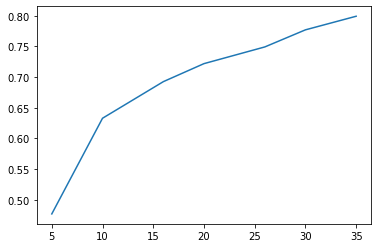

In [93]:
import matplotlib.pyplot as plt
plt.plot(list(result.keys()),list(float(mean(value)/2000) for value in result.values()))

### 4.02 😎 Run LCE(Zipf = 1, requests = 2000, topo = GEANT, hit_rate VS capability)

In [12]:
args = '-c 3 -s lce -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate(options)

2021-05-26 12:52:10,131 - root - INFO - Enable Debugging
2021-05-26 12:52:10,132 - root - DEBUG - Mobility disabled
2021-05-26 12:52:10,132 - root - DEBUG - Step printing activated
2021-05-26 12:52:10,162 - root - DEBUG - Social Graph loaded
#####################################################################
Round#  1
Start Simulating!
total seq num:  2000
CPU times: user 532 ms, sys: 19.8 ms, total: 552 ms
Wall time: 22 s
Round: 1 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 195 , stretch: 0.9379 hop_reduction: 0.0621 get_diversity: 0.5797 caching_operations: 5306 eviction_operations: 5306 Satisfied by caches: 195 _interest: 2000, get_rch: 0.0975
#####################################################################
Round#  2
Start Simulating!
total seq num:  4000
CPU times: user 535 ms, sys: 19.7 ms, total: 555 ms
Wall time: 42 s
Round: 2 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 231 , stretch: 0.923 hop_reduction: 0.077 get_diversity: 0.5507 c

In [13]:
result_5 = result

In [14]:
args = '-c 5 -s lce -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate(options)

2021-05-26 13:10:50,501 - root - INFO - Enable Debugging
2021-05-26 13:10:50,502 - root - DEBUG - Mobility disabled
2021-05-26 13:10:50,503 - root - DEBUG - Step printing activated
2021-05-26 13:10:50,503 - root - DEBUG - Social Graph loaded
#####################################################################
Round#  1
Start Simulating!
total seq num:  2000
CPU times: user 524 ms, sys: 19.2 ms, total: 544 ms
Wall time: 22 s
Round: 1 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 274 , stretch: 0.903 hop_reduction: 0.097 get_diversity: 0.5565 caching_operations: 5105 eviction_operations: 5105 Satisfied by caches: 274 _interest: 2000, get_rch: 0.137
#####################################################################
Round#  2
Start Simulating!
total seq num:  4000
CPU times: user 523 ms, sys: 19.3 ms, total: 542 ms
Wall time: 42 s
Round: 2 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 275 , stretch: 0.9136 hop_reduction: 0.0864 get_diversity: 0.5478 ca

In [15]:
result_10 = result

In [16]:
args = '-c 8 -s lce -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate(options)

2021-05-26 13:46:05,311 - root - INFO - Enable Debugging
2021-05-26 13:46:05,311 - root - DEBUG - Mobility disabled
2021-05-26 13:46:05,312 - root - DEBUG - Step printing activated
2021-05-26 13:46:05,312 - root - DEBUG - Social Graph loaded
#####################################################################
Round#  1
Start Simulating!
total seq num:  2000
CPU times: user 526 ms, sys: 19.4 ms, total: 545 ms
Wall time: 22 s
Round: 1 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 365 , stretch: 0.8795 hop_reduction: 0.1205 get_diversity: 0.5 caching_operations: 4933 eviction_operations: 4933 Satisfied by caches: 365 _interest: 2000, get_rch: 0.1825
#####################################################################
Round#  2
Start Simulating!
total seq num:  4000
CPU times: user 565 ms, sys: 23 ms, total: 588 ms
Wall time: 42 s
Round: 2 , internal_hit: 0 , internal_miss: 0 , stretch : 0 , cacheHit: 376 , stretch: 0.8725 hop_reduction: 0.1275 get_diversity: 0.4891 cach

In [ ]:
result_15 = result

In [ ]:
args = '-c 10 -s lce -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate(options)

2021-05-26 14:04:45,595 - root - INFO - Enable Debugging
2021-05-26 14:04:45,596 - root - DEBUG - Mobility disabled
2021-05-26 14:04:45,597 - root - DEBUG - Step printing activated
2021-05-26 14:04:45,597 - root - DEBUG - Social Graph loaded
#####################################################################
Round#  1
Start Simulating!
total seq num:  2000


In [ ]:
result_20 = resul

In [ ]:
args = '-c 13 -s lce -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate(options)

In [ ]:
result_25 = result

In [ ]:
args = '-c 15 -s lce -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate(options)

In [ ]:
result_30 = result

In [ ]:
args = '-c 18 -s lce -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate(options)

In [ ]:
result_35 = result

## 5 😯 Configure and run for different zipf parameter

In [12]:
import warnings
warnings.filterwarnings('ignore')

In [13]:
def simulate_zipf(options):
    logger = setup_logger('logger', 'example.log', level=logging.CRITICAL)
    cache_info = setup_logger('cache_info', 'cache_info.log', level = logging.CRITICAL)
    if options.debug:
        root = logging.getLogger()
        root.setLevel(logging.DEBUG)
        ch = logging.StreamHandler(sys.stdout)
        ch.setLevel(logging.DEBUG)
        formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
        ch.setFormatter(formatter)
        root.addHandler(ch)
        root.info('Enable Debugging')
        # delivering original parameters
    CACHE_SIZE = options.cache_size_per_node
    CACHING_STRATEGY = options.caching_strategy
    ## Configure Cache
    RUNS = 10
    SOCIAL_GRAPH = options.social_graph
    TOPOLOGY_GRAPH = options.network_topology
    CACHE_STRUCTURE = options.replacement_policy
    SEQUENCE_FILE = options.trace
    ZIPF = options.zipf
    SINGLE = options.single
    VERBOSE = options.verbose
    ZIPF_PARAMETER = options.zipf_parameter
    if SEQUENCE_FILE == "":
        logging.error("no trace file, using random generation of messages.")
        exit()
    METHOD = options.method
    if METHOD not in ['random','geographical','onepublisher']:
        root.error("WARNING, method is not listed, set to random")
        METHOD = 'random'
    MOBILITY_ENABLED = options.mobility_enabled
    if MOBILITY_ENABLED:
        root.debug("Mobility enabled")
    else:
        root.debug("Mobility disabled")

    try:
        STEP_PRINTING = [float(x) for x in options.step_printing.split(",") if x != '']
        root.debug("Step printing activated")
    except IndexError:
        STEP_PRINTING = []
        root.debug("Step printing not activated")
    CACHE_STRUCTURE = re.match('([a-zA-Z0-9_]*(\((?P<params>([0-9]*\.?[0-9]*,? ?)*)\))?)', CACHE_STRUCTURE)
    assert CACHE_STRUCTURE != None
    CACHE_STRUCTURE = CACHE_STRUCTURE.group(1)
    # Import Social Graph
    # Social Graph from folder graphs
    G = getattr(__import__('graphs.%s'%SOCIAL_GRAPH), SOCIAL_GRAPH).G
    #plotGraph(G)
    root.debug('Social Graph loaded')
    #random.seed(10442)
    # Import Topology Graph as a new class(peterson and pharse as topology class)
    # social_graph is imported as a new class from folder graph, in this case, alibama
    petersen = getattr(__import__('graphs.%s'%TOPOLOGY_GRAPH), TOPOLOGY_GRAPH).G
    #plotGraph(petersen)
    # social_graph, topology, cache_size, caching_strategy, cache_policy, sequence_filename, mobility_enabled, step_printing, topology_file
    executor = Executor(logger,G, petersen, CACHE_SIZE, CACHING_STRATEGY, CACHE_STRUCTURE, SEQUENCE_FILE, MOBILITY_ENABLED, STEP_PRINTING, topology_file=TOPOLOGY_GRAPH, zipf = ZIPF, method = METHOD, single = SINGLE, verbose = VERBOSE) 
    executor.set_zipf_parameter(ZIPF_PARAMETER)
    offset = [0,2,4,6,8,10,12,14,16,18,20]
    for i in range(0, RUNS):
        #print(executor.caches.print_caches())
        print("#####################################################################")
        print("Round# ", i+1)
        %time executor.run(offset = offset[i])
        try:
            executor.caches.update_predict_result()
        except:
            "Not POP, do not update prediction"
        print(executor.printStats())
        if options.caching_strategy.upper() == "POP":
            result.append(executor.caches.stats._internal_hit)
        else:
            result.append(executor.caches.stats._hit)
        #print(executor.caches.print_caches())
        executor.caches.stats.reset()
        executor.seq_n = 0
        #print(executor.caches.pop)
    executor.finishSimulation()
    root.handlers.pop()
    logger = logging.getLogger('logger')
    while logger.handlers:
        logger.handlers.pop()
    cache_info = logging.getLogger('cache_info')
    while cache_info.handlers:
        cache_info.handlers.pop()

### 5.01 😎 Run Zipf(POP, requests = 2000, topo = GEANT, hit_rate VS capability)

In [14]:
args = '-c 10 -s pop -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True -a 0.2'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate_zipf(options)

2021-05-27 11:05:35,953 - root - INFO - Enable Debugging
2021-05-27 11:05:35,954 - root - DEBUG - Mobility disabled
2021-05-27 11:05:35,955 - root - DEBUG - Step printing activated
2021-05-27 11:05:35,956 - root - DEBUG - Social Graph loaded
#####################################################################
Round#  1
Start Simulating!
total seq num:  2000
CPU times: user 257 ms, sys: 17.5 ms, total: 275 ms
Wall time: 22 s
Round: 1 , internal_hit: 429 , internal_miss: 1571 , stretch : 3788 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 1571 eviction_operations: 1571 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  2
Start Simulating!
total seq num:  2000
CPU times: user 263 ms, sys: 18.6 ms, total: 281 ms
Wall time: 22 s
Round: 2 , internal_hit: 433 , internal_miss: 1567 , stretch : 3696 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operati

In [15]:
result_zipf_2 = result

In [16]:
args = '-c 10 -s pop -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True -a 0.4'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate_zipf(options)

2021-05-27 11:10:55,994 - root - INFO - Enable Debugging
2021-05-27 11:10:55,996 - root - DEBUG - Mobility disabled
2021-05-27 11:10:55,997 - root - DEBUG - Step printing activated
2021-05-27 11:10:55,998 - root - DEBUG - Social Graph loaded
#####################################################################
Round#  1
Start Simulating!
total seq num:  2000
CPU times: user 269 ms, sys: 19.6 ms, total: 288 ms
Wall time: 22 s
Round: 1 , internal_hit: 455 , internal_miss: 1545 , stretch : 3747 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 1545 eviction_operations: 1545 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  2
Start Simulating!
total seq num:  2000
CPU times: user 298 ms, sys: 24.3 ms, total: 322 ms
Wall time: 22 s
Round: 2 , internal_hit: 521 , internal_miss: 1479 , stretch : 3477 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operati

In [17]:
result_zipf_4 = result

In [18]:
args = '-c 10 -s pop -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True -a 0.6'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate_zipf(options)

2021-05-27 11:15:00,298 - root - INFO - Enable Debugging
2021-05-27 11:15:00,299 - root - DEBUG - Mobility disabled
2021-05-27 11:15:00,299 - root - DEBUG - Step printing activated
2021-05-27 11:15:00,299 - root - DEBUG - Social Graph loaded
#####################################################################
Round#  1
Start Simulating!
total seq num:  2000
CPU times: user 254 ms, sys: 17.9 ms, total: 272 ms
Wall time: 22 s
Round: 1 , internal_hit: 610 , internal_miss: 1390 , stretch : 3367 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 1390 eviction_operations: 1390 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  2
Start Simulating!
total seq num:  2000
CPU times: user 254 ms, sys: 17.4 ms, total: 271 ms
Wall time: 22 s
Round: 2 , internal_hit: 675 , internal_miss: 1325 , stretch : 3084 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operati

In [19]:
result_zipf_6 = result

In [20]:
args = '-c 10 -s pop -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True -a 0.8'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate_zipf(options)

2021-05-27 11:19:03,424 - root - INFO - Enable Debugging
2021-05-27 11:19:03,424 - root - DEBUG - Mobility disabled
2021-05-27 11:19:03,424 - root - DEBUG - Step printing activated
2021-05-27 11:19:03,425 - root - DEBUG - Social Graph loaded
#####################################################################
Round#  1
Start Simulating!
total seq num:  2000
CPU times: user 255 ms, sys: 18 ms, total: 273 ms
Wall time: 22 s
Round: 1 , internal_hit: 896 , internal_miss: 1104 , stretch : 2613 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 1104 eviction_operations: 1104 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  2
Start Simulating!
total seq num:  2000
CPU times: user 247 ms, sys: 17.2 ms, total: 265 ms
Wall time: 22 s
Round: 2 , internal_hit: 884 , internal_miss: 1116 , stretch : 2636 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operation

In [21]:
result_zipf_8 = result

In [22]:
args = '-c 10 -s pop -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True -a 1.0'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate_zipf(options)

2021-05-27 11:23:05,468 - root - INFO - Enable Debugging
2021-05-27 11:23:05,469 - root - DEBUG - Mobility disabled
2021-05-27 11:23:05,469 - root - DEBUG - Step printing activated
2021-05-27 11:23:05,469 - root - DEBUG - Social Graph loaded
#####################################################################
Round#  1
Start Simulating!
total seq num:  2000
CPU times: user 286 ms, sys: 20.6 ms, total: 306 ms
Wall time: 22 s
Round: 1 , internal_hit: 1155 , internal_miss: 845 , stretch : 2045 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 845 eviction_operations: 845 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  2
Start Simulating!
total seq num:  2000
CPU times: user 251 ms, sys: 17.1 ms, total: 268 ms
Wall time: 22 s
Round: 2 , internal_hit: 1224 , internal_miss: 776 , stretch : 1847 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operation

In [23]:
result_zipf_10 = result

In [24]:
args = '-c 10 -s pop -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True -a 1.2'
(options,args) = parser.parse_args(args.split(' '))
result = []
simulate_zipf(options)

2021-05-27 11:27:04,775 - root - INFO - Enable Debugging
2021-05-27 11:27:04,775 - root - DEBUG - Mobility disabled
2021-05-27 11:27:04,775 - root - DEBUG - Step printing activated
2021-05-27 11:27:04,775 - root - DEBUG - Social Graph loaded
#####################################################################
Round#  1
Start Simulating!
total seq num:  2000
CPU times: user 264 ms, sys: 20.7 ms, total: 284 ms
Wall time: 22 s
Round: 1 , internal_hit: 1478 , internal_miss: 522 , stretch : 1247 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 522 eviction_operations: 522 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  2
Start Simulating!
total seq num:  2000
CPU times: user 302 ms, sys: 22.1 ms, total: 324 ms
Wall time: 22 s
Round: 2 , internal_hit: 1515 , internal_miss: 485 , stretch : 1134 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operation

In [25]:
result_zipf_12 = result

In [31]:
result = {}
result[0.2] = result_zipf_2
result[0.4] = result_zipf_4
result[0.6] = result_zipf_6
result[0.8] = result_zipf_8
result[1.0] = result_zipf_10
result[1.2] = result_zipf_12

In [32]:
if not os.path.exists('result'):
    os.mkdir('result')
os.chdir('result/')
if not os.path.exists('zipf'):
    os.mkdir('zipf')
os.chdir('zipf')
filename = 'result_POP.pickle'
import pickle
f = open(filename, 'wb')
pickle.dump(result,f)
f.close()
os.chdir('../')
os.chdir('../')

## 6 😯 Configure and run for different cache_size analyze stretches

In [26]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def simulate_hops(options):
    logger = setup_logger('logger', 'example.log', level=logging.CRITICAL)
    cache_info = setup_logger('cache_info', 'cache_info.log', level = logging.CRITICAL)
    if options.debug:
        root = logging.getLogger()
        root.setLevel(logging.DEBUG)
        ch = logging.StreamHandler(sys.stdout)
        ch.setLevel(logging.DEBUG)
        formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
        ch.setFormatter(formatter)
        root.addHandler(ch)
        root.info('Enable Debugging')
        # delivering original parameters
    CACHE_SIZE = options.cache_size_per_node
    CACHING_STRATEGY = options.caching_strategy
    ## Configure Cache
    RUNS = 10
    SOCIAL_GRAPH = options.social_graph
    TOPOLOGY_GRAPH = options.network_topology
    CACHE_STRUCTURE = options.replacement_policy
    SEQUENCE_FILE = options.trace
    ZIPF = options.zipf
    SINGLE = options.single
    VERBOSE = options.verbose
    ZIPF_PARAMETER = options.zipf_parameter
    if SEQUENCE_FILE == "":
        logging.error("no trace file, using random generation of messages.")
        exit()
    METHOD = options.method
    if METHOD not in ['random','geographical','onepublisher']:
        root.error("WARNING, method is not listed, set to random")
        METHOD = 'random'
    MOBILITY_ENABLED = options.mobility_enabled
    if MOBILITY_ENABLED:
        root.debug("Mobility enabled")
    else:
        root.debug("Mobility disabled")

    try:
        STEP_PRINTING = [float(x) for x in options.step_printing.split(",") if x != '']
        root.debug("Step printing activated")
    except IndexError:
        STEP_PRINTING = []
        root.debug("Step printing not activated")
    CACHE_STRUCTURE = re.match('([a-zA-Z0-9_]*(\((?P<params>([0-9]*\.?[0-9]*,? ?)*)\))?)', CACHE_STRUCTURE)
    assert CACHE_STRUCTURE != None
    CACHE_STRUCTURE = CACHE_STRUCTURE.group(1)
    # Import Social Graph
    # Social Graph from folder graphs
    G = getattr(__import__('graphs.%s'%SOCIAL_GRAPH), SOCIAL_GRAPH).G
    #plotGraph(G)
    root.debug('Social Graph loaded')
    #random.seed(10442)
    # Import Topology Graph as a new class(peterson and pharse as topology class)
    # social_graph is imported as a new class from folder graph, in this case, alibama
    petersen = getattr(__import__('graphs.%s'%TOPOLOGY_GRAPH), TOPOLOGY_GRAPH).G
    #plotGraph(petersen)
    # social_graph, topology, cache_size, caching_strategy, cache_policy, sequence_filename, mobility_enabled, step_printing, topology_file
    executor = Executor(logger,G, petersen, CACHE_SIZE, CACHING_STRATEGY, CACHE_STRUCTURE, SEQUENCE_FILE, MOBILITY_ENABLED, STEP_PRINTING, topology_file=TOPOLOGY_GRAPH, zipf = ZIPF, method = METHOD, single = SINGLE, verbose = VERBOSE) 
    executor.set_zipf_parameter(ZIPF_PARAMETER)
    offset = [0,2,4,6,8,10,12,14,16,18,20]
    for i in range(0, RUNS):
        #print(executor.caches.print_caches())
        print("#####################################################################")
        print("Round# ", i+1)
        %time executor.run(offset = offset[i])
        try:
            executor.caches.update_predict_result()
        except:
            "Not POP, do not update prediction"
        print(executor.printStats())
        #if options.caching_strategy.upper() == "POP":
        #    result.append(executor.caches.stats._internal_hit)
        #else:
        #    result.append(executor.caches.stats._hit)
        #print(executor.caches.print_caches())
        AS_hops,original_hops = executor.caches.stats.get_hops()
        result['original'].append(original_hops)
        result['AS_hops'].append(AS_hops)
        executor.caches.stats.reset()
        executor.seq_n = 0
        #print(executor.caches.pop)
    executor.finishSimulation()
    root.handlers.pop()
    logger = logging.getLogger('logger')
    while logger.handlers:
        logger.handlers.pop()
    cache_info = logging.getLogger('cache_info')
    while cache_info.handlers:
        cache_info.handlers.pop()

In [28]:
args = '-c 3 -s pop -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True'
(options,args) = parser.parse_args(args.split(' '))
result = {}
result['original'] = []
result['AS_hops'] = []
simulate_hops(options)

2021-05-27 13:36:55,509 - root - INFO - Enable Debugging
2021-05-27 13:36:55,510 - root - DEBUG - Mobility disabled
2021-05-27 13:36:55,510 - root - DEBUG - Step printing activated
2021-05-27 13:36:55,511 - root - DEBUG - Social Graph loaded
#####################################################################
Round#  1
Start Simulating!
total seq num:  2000
CPU times: user 298 ms, sys: 22.9 ms, total: 321 ms
Wall time: 22 s
Round: 1 , internal_hit: 761 , internal_miss: 1239 , stretch : 2938 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 1239 eviction_operations: 1239 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  2
Start Simulating!
total seq num:  2000
CPU times: user 268 ms, sys: 19.3 ms, total: 287 ms
Wall time: 22 s
Round: 2 , internal_hit: 756 , internal_miss: 1244 , stretch : 2986 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operati

In [29]:
hops_5 = result

In [30]:
hops_5

{'original': [3764, 3734, 3738, 3764, 3739, 3726, 3680, 3770, 3675, 3751],
 'AS_hops': [7124, 7203, 7313, 6802, 6727, 6921, 7264, 7042, 7309, 7009]}

In [31]:
args = '-c 5 -s pop -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True'
(options,args) = parser.parse_args(args.split(' '))
result = {}
result['original'] = []
result['AS_hops'] = []
simulate_hops(options)

2021-05-27 13:42:49,111 - root - INFO - Enable Debugging
2021-05-27 13:42:49,112 - root - DEBUG - Mobility disabled
2021-05-27 13:42:49,112 - root - DEBUG - Step printing activated
2021-05-27 13:42:49,113 - root - DEBUG - Social Graph loaded
#####################################################################
Round#  1
Start Simulating!
total seq num:  2000
CPU times: user 280 ms, sys: 24.1 ms, total: 304 ms
Wall time: 22 s
Round: 1 , internal_hit: 968 , internal_miss: 1032 , stretch : 2404 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 1032 eviction_operations: 1032 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  2
Start Simulating!
total seq num:  2000
CPU times: user 255 ms, sys: 19.1 ms, total: 275 ms
Wall time: 22 s
Round: 2 , internal_hit: 926 , internal_miss: 1074 , stretch : 2569 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operati

In [32]:
hops_10 = result

In [33]:
args = '-c 8 -s pop -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True'
(options,args) = parser.parse_args(args.split(' '))
result = {}
result['original'] = []
result['AS_hops'] = []
simulate_hops(options)

2021-05-27 13:46:48,435 - root - INFO - Enable Debugging
2021-05-27 13:46:48,436 - root - DEBUG - Mobility disabled
2021-05-27 13:46:48,436 - root - DEBUG - Step printing activated
2021-05-27 13:46:48,437 - root - DEBUG - Social Graph loaded
#####################################################################
Round#  1
Start Simulating!
total seq num:  2000
CPU times: user 298 ms, sys: 25.9 ms, total: 324 ms
Wall time: 22 s
Round: 1 , internal_hit: 1098 , internal_miss: 902 , stretch : 2156 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 902 eviction_operations: 902 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  2
Start Simulating!
total seq num:  2000
CPU times: user 317 ms, sys: 26.8 ms, total: 344 ms
Wall time: 22 s
Round: 2 , internal_hit: 1137 , internal_miss: 863 , stretch : 2044 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operation

In [34]:
hops_15 = result

In [35]:
args = '-c 10 -s pop -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True'
(options,args) = parser.parse_args(args.split(' '))
result = {}
result['original'] = []
result['AS_hops'] = []
simulate_hops(options)

2021-05-27 13:50:48,267 - root - INFO - Enable Debugging
2021-05-27 13:50:48,267 - root - DEBUG - Mobility disabled
2021-05-27 13:50:48,267 - root - DEBUG - Step printing activated
2021-05-27 13:50:48,268 - root - DEBUG - Social Graph loaded
#####################################################################
Round#  1
Start Simulating!
total seq num:  2000
CPU times: user 264 ms, sys: 18.5 ms, total: 282 ms
Wall time: 22 s
Round: 1 , internal_hit: 1203 , internal_miss: 797 , stretch : 1871 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 797 eviction_operations: 797 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  2
Start Simulating!
total seq num:  2000
CPU times: user 263 ms, sys: 20.9 ms, total: 284 ms
Wall time: 22 s
Round: 2 , internal_hit: 1212 , internal_miss: 788 , stretch : 1861 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operation

In [36]:
hops_20 = result

In [38]:
args = '-c 13 -s pop -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True'
(options,args) = parser.parse_args(args.split(' '))
result = {}
result['original'] = []
result['AS_hops'] = []
simulate_hops(options)

2021-05-27 13:56:25,523 - root - INFO - Enable Debugging
2021-05-27 13:56:25,523 - root - INFO - Enable Debugging
2021-05-27 13:56:25,524 - root - DEBUG - Mobility disabled
2021-05-27 13:56:25,524 - root - DEBUG - Mobility disabled
2021-05-27 13:56:25,525 - root - DEBUG - Step printing activated
2021-05-27 13:56:25,525 - root - DEBUG - Step printing activated
2021-05-27 13:56:25,526 - root - DEBUG - Social Graph loaded
2021-05-27 13:56:25,526 - root - DEBUG - Social Graph loaded
#####################################################################
Round#  1
Start Simulating!
total seq num:  2000
CPU times: user 276 ms, sys: 24 ms, total: 300 ms
Wall time: 22 s
Round: 1 , internal_hit: 1287 , internal_miss: 713 , stretch : 1672 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 713 eviction_operations: 713 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  2
Start Simulating!
t

In [39]:
hops_25 = result

In [40]:
args = '-c 15 -s pop -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True'
(options,args) = parser.parse_args(args.split(' '))
result = {}
result['original'] = []
result['AS_hops'] = []
simulate_hops(options)

2021-05-27 14:00:24,867 - root - INFO - Enable Debugging
2021-05-27 14:00:24,867 - root - INFO - Enable Debugging
2021-05-27 14:00:24,868 - root - DEBUG - Mobility disabled
2021-05-27 14:00:24,868 - root - DEBUG - Mobility disabled
2021-05-27 14:00:24,868 - root - DEBUG - Step printing activated
2021-05-27 14:00:24,868 - root - DEBUG - Step printing activated
2021-05-27 14:00:24,868 - root - DEBUG - Social Graph loaded
2021-05-27 14:00:24,868 - root - DEBUG - Social Graph loaded
#####################################################################
Round#  1
Start Simulating!
total seq num:  2000
CPU times: user 243 ms, sys: 20.5 ms, total: 263 ms
Wall time: 22 s
Round: 1 , internal_hit: 1298 , internal_miss: 702 , stretch : 1664 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 702 eviction_operations: 702 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  2
Start Simulating!

In [41]:
hops_30 = result

In [42]:
args = '-c 18 -s pop -u facebook -t geant -p lru -f exampletrace/verysmall -d True -z True -e geographical -g True -v True'
(options,args) = parser.parse_args(args.split(' '))
result = {}
result['original'] = []
result['AS_hops'] = []
simulate_hops(options)

2021-05-27 14:04:23,869 - root - INFO - Enable Debugging
2021-05-27 14:04:23,869 - root - INFO - Enable Debugging
2021-05-27 14:04:23,870 - root - DEBUG - Mobility disabled
2021-05-27 14:04:23,870 - root - DEBUG - Mobility disabled
2021-05-27 14:04:23,870 - root - DEBUG - Step printing activated
2021-05-27 14:04:23,870 - root - DEBUG - Step printing activated
2021-05-27 14:04:23,870 - root - DEBUG - Social Graph loaded
2021-05-27 14:04:23,870 - root - DEBUG - Social Graph loaded
#####################################################################
Round#  1
Start Simulating!
total seq num:  2000
CPU times: user 249 ms, sys: 20.8 ms, total: 270 ms
Wall time: 22 s
Round: 1 , internal_hit: 1381 , internal_miss: 619 , stretch : 1445 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 619 eviction_operations: 619 Satisfied by caches: 0 _interest: 0, get_rch: 0
#####################################################################
Round#  2
Start Simulating!

In [43]:
hops_35 = result

In [44]:
result = {}
result['original'] = {}
result['AS_hops'] = {}
result['original'][5] = hops_5['original']
result['original'][10] = hops_10['original']
result['original'][16] = hops_15['original']
result['original'][20] = hops_20['original']
result['original'][26] = hops_25['original']
result['original'][30] = hops_30['original']
result['original'][35] = hops_35['original']
result['AS_hops'][5] = hops_5['AS_hops']
result['AS_hops'][10] = hops_10['AS_hops']
result['AS_hops'][16] = hops_15['AS_hops']
result['AS_hops'][20] = hops_20['AS_hops']
result['AS_hops'][26] = hops_25['AS_hops']
result['AS_hops'][30] = hops_30['AS_hops']
result['AS_hops'][35] = hops_35['AS_hops']

In [45]:
if not os.path.exists('result'):
    os.mkdir('result')
os.chdir('result/')
if not os.path.exists('hops'):
    os.mkdir('hops')
os.chdir('hops')
filename = 'result_POP.pickle'
import pickle
f = open(filename, 'wb')
pickle.dump(result,f)
f.close()

## 🥸 Show request pattern of different contents

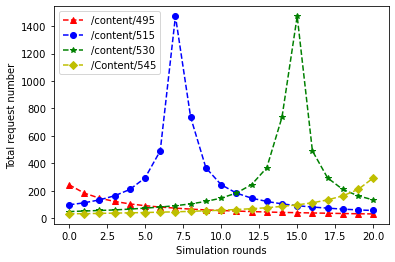

In [62]:
offset = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
contents = ["/content/%s"%str(i) for i in range(1000)]
patterns = {}
for i in range(len(offset)):
    req, pattern = gen_bilateral_biased_zipf_requests(alpha = 1,number_of_content = 1000, number_of_request = 10000, offset = 2*offset[i])
    patterns[i] = pattern
    #plt.plot(pattern.keys(), pattern.values())
data = []
for i in range(len(offset)):
    #print(patterns[i])
    data.append(patterns[i][495])
plt.plot(offset,data,'r--^')
data = []
for i in range(len(offset)):
    #print(patterns[i])
    data.append(patterns[i][515])
plt.plot(offset,data,'b--o')
data = []
for i in range(len(offset)):
    #print(patterns[i])
    data.append(patterns[i][530])
plt.plot(offset,data,'g--*')
data = []
for i in range(len(offset)):
    #print(patterns[i])
    data.append(patterns[i][545])
plt.plot(offset,data,'y--D')
plt.legend(['/content/495','/content/515','/content/530','/Content/545'])
plt.xlabel('Simulation rounds')
plt.ylabel('Total request number')
if not os.path.exists('result/'):
    os.mkdir('result/')
os.chdir('result')
plt.savefig('request_pattern.png')
os.chdir('../')

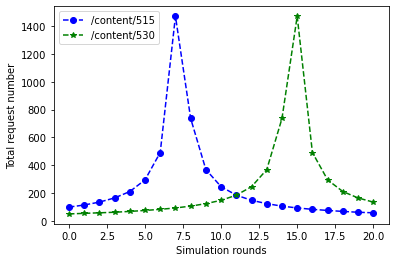

In [23]:
offset = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
contents = ["/content/%s"%str(i) for i in range(1000)]
patterns = {}
for i in range(len(offset)):
    req, pattern = gen_bilateral_biased_zipf_requests(alpha = 1,number_of_content = 1000, number_of_request = 10000, offset = 2*offset[i])
    patterns[i] = pattern
    #plt.plot(pattern.keys(), pattern.values())
data = []
for i in range(len(offset)):
    #print(patterns[i])
    data.append(patterns[i][515])
plt.plot(offset,data,'b--o')

data = []
for i in range(len(offset)):
    #print(patterns[i])
    data.append(patterns[i][530])
plt.plot(offset,data,'g--*')
plt.legend(['/content/515','/content/530'])
plt.xlabel('Simulation rounds')
plt.ylabel('Total request number')
if not os.path.exists('result/'):
    os.mkdir('result/')
os.chdir('result')
plt.savefig('request_pattern.png')
os.chdir('../')

## 5 Visualization

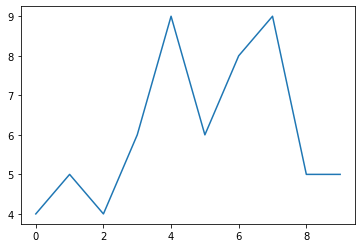

In [19]:
import matplotlib.pyplot as plt
plt.plot(result)

In [17]:
    logger = setup_logger('logger', 'example.log', level=logging.CRITICAL)
    cache_info = setup_logger('cache_info', 'cache_info.log', level = logging.CRITICAL)
    if options.debug:
        root = logging.getLogger()
        root.setLevel(logging.DEBUG)
        ch = logging.StreamHandler(sys.stdout)
        ch.setLevel(logging.DEBUG)
        formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
        ch.setFormatter(formatter)
        root.addHandler(ch)
        root.info('Enable Debugging')
        # delivering original parameters
    CACHE_SIZE = options.cache_size_per_node
    CACHING_STRATEGY = options.caching_strategy
    ## Configure Cache
    RUNS = 1
    SOCIAL_GRAPH = options.social_graph
    TOPOLOGY_GRAPH = options.network_topology
    CACHE_STRUCTURE = options.replacement_policy
    SEQUENCE_FILE = options.trace
    ZIPF = options.zipf
    SINGLE = options.single
    VERBOSE = options.verbose
    ZIPF_PARAMETER = options.zipf_parameter
    if SEQUENCE_FILE == "":
        logging.error("no trace file, using random generation of messages.")
        exit()
    METHOD = options.method
    if METHOD not in ['random','geographical','onepublisher']:
        root.error("WARNING, method is not listed, set to random")
        METHOD = 'random'
    MOBILITY_ENABLED = options.mobility_enabled
    if MOBILITY_ENABLED:
        root.debug("Mobility enabled")
    else:
        root.debug("Mobility disabled")

    try:
        STEP_PRINTING = [float(x) for x in options.step_printing.split(",") if x != '']
        root.debug("Step printing activated")
    except IndexError:
        STEP_PRINTING = []
        root.debug("Step printing not activated")
    CACHE_STRUCTURE = re.match('([a-zA-Z0-9_]*(\((?P<params>([0-9]*\.?[0-9]*,? ?)*)\))?)', CACHE_STRUCTURE)
    assert CACHE_STRUCTURE != None
    CACHE_STRUCTURE = CACHE_STRUCTURE.group(1)
    # Import Social Graph
    # Social Graph from folder graphs
    G = getattr(__import__('graphs.%s'%SOCIAL_GRAPH), SOCIAL_GRAPH).G
    #plotGraph(G)
    root.debug('Social Graph loaded')
    #random.seed(10442)
    # Import Topology Graph as a new class(peterson and pharse as topology class)
    # social_graph is imported as a new class from folder graph, in this case, alibama
    petersen = getattr(__import__('graphs.%s'%TOPOLOGY_GRAPH), TOPOLOGY_GRAPH).G
    #plotGraph(petersen)
    # social_graph, topology, cache_size, caching_strategy, cache_policy, sequence_filename, mobility_enabled, step_printing, topology_file
    executor = Executor(logger,G, petersen, CACHE_SIZE, CACHING_STRATEGY, CACHE_STRUCTURE, SEQUENCE_FILE, MOBILITY_ENABLED, STEP_PRINTING, topology_file=TOPOLOGY_GRAPH, zipf = ZIPF, method = METHOD, single = SINGLE, verbose = VERBOSE) 
    executor.set_zipf_parameter(ZIPF_PARAMETER)
    offset = [0,2,4,6,8,10,12,14,16,18,20]
    for i in range(0, RUNS):
        #print(executor.caches.print_caches())
        print("#####################################################################")
        print("Round# ", i+1)
        %time executor.run(offset = offset[i])
        try:
            executor.caches.update_predict_result()
        except:
            "Not POP, do not update prediction"
        print(executor.printStats())
        #if options.caching_strategy.upper() == "POP":
        #    result.append(executor.caches.stats._internal_hit)
        #else:
        #    result.append(executor.caches.stats._hit)
        #print(executor.caches.print_caches())
        AS_hops,original_hops = executor.caches.stats.get_hops()
        #result['original'].append(original_hops)
        #result['AS_hops'].append(AS_hops)
        executor.caches.stats.reset()
        executor.seq_n = 0
        #print(executor.caches.pop)
    executor.finishSimulation()
    root.handlers.pop()
    logger = logging.getLogger('logger')
    while logger.handlers:
        logger.handlers.pop()
    cache_info = logging.getLogger('cache_info')
    while cache_info.handlers:
        cache_info.handlers.pop()

2021-05-28 09:59:50,227 - root - INFO - Enable Debugging
2021-05-28 09:59:50,227 - root - INFO - Enable Debugging
2021-05-28 09:59:50,227 - root - DEBUG - Mobility disabled
2021-05-28 09:59:50,227 - root - DEBUG - Mobility disabled
2021-05-28 09:59:50,228 - root - DEBUG - Step printing activated
2021-05-28 09:59:50,228 - root - DEBUG - Step printing activated
2021-05-28 09:59:50,229 - root - DEBUG - Social Graph loaded
2021-05-28 09:59:50,229 - root - DEBUG - Social Graph loaded
#####################################################################
Round#  1
Start Simulating!
total seq num:  2000
CPU times: user 188 ms, sys: 15.6 ms, total: 203 ms
Wall time: 4.01 s
Round: 1 , internal_hit: 956 , internal_miss: 1044 , stretch : 2495 , cacheHit: 0 , stretch: 0.0 hop_reduction: 0.0 get_diversity: 1.0 caching_operations: 1044 eviction_operations: 1044 Satisfied by caches: 0 _interest: 0, get_rch: 0


In [18]:
#TOPOLOGY_GRAPH = options.network_topology
#G = getattr(__import__('graphs.%s'%TOPOLOGY_GRAPH), TOPOLOGY_GRAPH).G
G = executor.topology
topo_vis = vis(G, executor.topology_coords)
node = random.choice(list(G.nodes()))
G.add_node("server", label = "server")
G.add_edge(node,"server")

In [ ]:
AS1 = AS(list(G.nodes()),True)
print(AS1.get_nodes())
AS1.get_node("coconut")

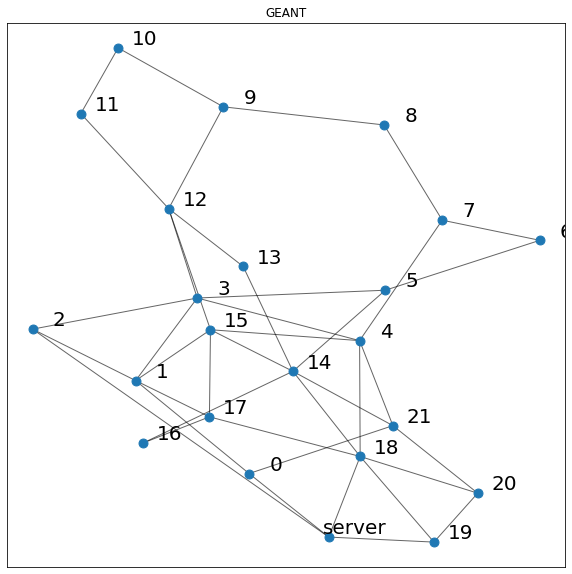

In [22]:
pos = executor.topology_coords
Gcc = G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0])
fig = plt.figure(figsize=(10, 10))
ax0 = fig.subplots()
nx.draw_networkx_nodes(G, pos,  node_size = 80)
nx.draw_networkx_edges(G,pos, alpha = 0.6)
pos1 = {}
for p in pos:  # raise text positions
    #pos[p] = [p[0]+0.05, p[1]+0.04]
    pos1[p] = pos[p][0]+0.05,pos[p][1]+0.03
plt.title(options.network_topology.upper())
nx.draw_networkx_labels(G, pos1,  font_size = 20)
#plt.show()
if not os.path.exists('result/'):
    os.mkdir('result/')
os.chdir('result')
plt.savefig('topology.png')
os.chdir('../')
        #print(pos, pos1)

In [ ]:
pos = nx.spring_layout(G)
nx.draw(G, pos, font_size=16)
for p in pos:  # raise text positions
    pos[p][0] += 0.05
    pos[p][1] += 0.09
nx.draw_networkx_labels(G, pos)
plt.show()

In [ ]:
topo_vis.label_graph(font_size = 1, node_size = 210)

# 节点的介度

In [ ]:
print("Betweenness")
b = nx.betweenness_centrality(G)
for v in G.nodes():
    print("%0.2d %5.3f" % (v, b[v]))

print("Degree centrality")
d = nx.degree_centrality(G)
for v in G.nodes():
    print("%0.2d %5.3f" % (v, d[v]))

print("Closeness centrality")
c = nx.closeness_centrality(G)
for v in G.nodes():
    print("%0.2d %5.3f" % (v, c[v]))

nx.draw(G, pos, font_size=16)
for p in pos:  # raise text positions
    pos[p][0] += 0.05
    pos[p][1] += 0.09
nx.draw_networkx_labels(G, pos)
plt.show()

In [ ]:
print(sum(d.values()))

In [ ]:
print(44/21)

In [ ]:
SOCIAL_GRAPH = options.social_graph
G = getattr(__import__('graphs.%s'%SOCIAL_GRAPH), SOCIAL_GRAPH).G
social_vis = vis(G)

In [ ]:
social_vis.degree_graph()

In [ ]:
social_vis.simple_graph(node_size = 10, alpha = 0.2, size = 12)

In [ ]:
print("Betweenness")
b = nx.betweenness_centrality(G)
for v in G.nodes():
    print("%0.2d %5.3f" % (v, b[v]))

print("Degree centrality")
d = nx.degree_centrality(G)
for v in G.nodes():
    print("%0.2d %5.3f" % (v, d[v]))

print("Closeness centrality")
c = nx.closeness_centrality(G)
for v in G.nodes():
    print("%0.2d %5.3f" % (v, c[v]))

pos = nx.spring_layout(G)
nx.draw(G, pos, font_size=16)
for p in pos:  # raise text positions
    pos[p][0] += 0.05
    pos[p][1] += 0.09
nx.draw_networkx_labels(G, pos)
plt.show()

In [ ]:
topo_vis.directed_graph()

In [ ]:
topo_vis.degree_graph()

In [ ]:
topo_vis.simple_graph()

In [ ]:
args = '-c 2 -s lce -u facebook -t geant -p lru -f exampletrace/verysmall -d True'
(options,args) = parser.parse_args(args.split(' '))

In [ ]:
TOPOLOGY_GRAPH = options.network_topology
G = getattr(__import__('graphs.%s'%TOPOLOGY_GRAPH), TOPOLOGY_GRAPH).G
topo_vis = vis(G)

In [ ]:
topo_vis.degree_graph()

In [ ]:
G = nx.Graph()  # or DiGraph, MultiGraph, MultiDiGraph, etc
G.add_nodes_from("Hello")
K3 = nx.Graph([(0, 1), (1, 2), (2, 0)])
G.add_nodes_from(K3)

In [ ]:
viser = vis(G)
viser.directed_graph()

In [ ]:
viser.degree_graph()